### Using Image augmentation to improve performance on image classifier

The dataset comprises 100 food categories, each with ~1000 images. I will initially run a ResNet style model and get a benchmark for classification.

I will then use image augmentation, cropping and mirroring the images to increase the size of the training set to see if this increases performance

In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 454.3 MB 13 kB/s 
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
     |████████████████████████████████| 4.0 MB 82.9 MB/s 
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
     |████████████████████████████████| 57 kB 8.0 MB/s 
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
# import plotly
# import plotly.graph_objects as go
# import plotly.express as px
import datetime
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Flatten, Dense, Activation, Add
import matplotlib.pyplot as plt
from tensorflow.keras import activations
import os
from PIL import ImageOps

### Loading the images

The images are a range of sizes, and we'll handle this by converting them all to 128x128, padding the outside where necessary

Initially download using .tar file

In [3]:
# def get_data_extract():
#   if "food-101" in os.listdir():
#     print("Dataset already exists")
#   else:
#     tf.keras.utils.get_file(
#     'food-101.tar.gz',
#     'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
#     # cache_subdir='/content',
#     extract=True,
#     archive_format='tar',
#     cache_dir=None
#     )
#     print("Dataset downloaded and extracted!")
# get_data_extract()

In [2]:
#Open image into an 'image' object type
def image_to_vector(file,size=128):
    im_vec = Image.open(file)
    #calculate height and width
    width = im_vec.size[0]
    height = im_vec.size[1]
    #re-size to 1/4 of the size and convert to an array - we've already shown that this doesn't decrease performance
    resize_factor = max(width,height) / size
    im_vec = np.array(im_vec.resize((int(width//resize_factor),int(height//resize_factor))))
    
    width = im_vec.shape[0]
    height = im_vec.shape[1]
    #Pad it out to a full 128 by 128
    hor_pad_1 = int((size-im_vec.shape[0])/2)
    hor_pad_2 = int((size-im_vec.shape[0]+1)/2)
    ver_pad_1 = int((size - im_vec.shape[1])/2)
    ver_pad_2 = int((size - im_vec.shape[1]+1)/2)
    im_vec = np.pad(im_vec,pad_width=((hor_pad_1,hor_pad_2),(ver_pad_1,ver_pad_2),(0,0)))
    return im_vec
a= image_to_vector('/home/ubuntu/.keras/datasets/food-101/images/churros/1601.jpg')
# /home/ubuntu/.keras/datasets/food-101/images/churros/1601.jpg

### We will work with only the opening 20 food categories

In [5]:
'''Load in images of food'''

#go through all the images, put them into vector form, and then have a dictionary where each key is a type of image, and the value is a list of all those vectors.
list_of_food = []
unique_foods = {}
x = np.zeros((20000,128,128,3)).astype(np.uint8)
counter_cats, counter = 0,0
folder = '/home/ubuntu/.keras/datasets/food-101/images'
for food_cat in os.listdir(folder)[0:20]:
    print(food_cat)
    #there is a folder called .DS_store which we don't want
    if (food_cat == '.DS_Store'):
        continue
    unique_foods[counter_cats]=food_cat

    for file in os.listdir(f'{folder}/{food_cat}'):
        file_ = f'{folder}/{food_cat}/{file}'
        #here we are resizing
        try:
            im_vec = image_to_vector(file_)
            x[counter] = im_vec.astype(np.uint8)
            # plt.imshow(im_vec)
            list_of_food.append(food_cat)
            counter+=1
        except:
          print(f'{food_cat} had an error')
    counter_cats+=1

caesar_salad
cheesecake
churros
chicken_wings
chicken_wings had an error
hamburger
grilled_cheese_sandwich
scallops
lasagna
lasagna had an error
beef_tartare
chocolate_mousse
omelette
cheese_plate
clam_chowder
foie_gras
bibimbap
guacamole
cup_cakes
spaghetti_carbonara
macaroni_and_cheese
samosa


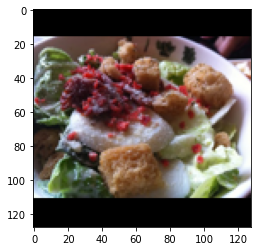

In [6]:
plt.imshow(x[1]); plt.show()

### Creating Y labels and preprocessing the data

In [7]:
#get list of each value in a series with value counts
df = pd.DataFrame(pd.Series(list_of_food).value_counts())
#initialise blank array
y=np.array([])
for food_idx, food in unique_foods.items():
    length =  df.loc[food]
    y  = np.append(y, np.zeros(length)+food_idx)
print(f'Y has {len(y)} numbers')
display(df.T)

Y has 19849 numbers


,foie_gras,churros,samosa,omelette,beef_tartare,guacamole,spaghetti_carbonara,hamburger,scallops,grilled_cheese_sandwich,clam_chowder,cheesecake,macaroni_and_cheese,cheese_plate,chocolate_mousse,cup_cakes,bibimbap,chicken_wings,lasagna,caesar_salad
0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,999,999,851


In [4]:
def tts_one_hot(x,y):
    #ensure parallel sizes in case of image errors
    x, y = x[:len(y)], y[:len(y)]

    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

    #normalise x values
    x_train, x_test = x_train/255, x_test/255
    one_hot = OneHotEncoder(sparse = False)

    #create one hot values for y, and reshape to an array
    one_hot_y_train= one_hot.fit_transform(y_train.reshape(-1,1))
    one_hot_y_test= one_hot.fit_transform(y_test.reshape(-1,1))
    return x_train, x_test, y_train, y_test, one_hot_y_train, one_hot_y_test

In [9]:
x_train, x_test, y_train, y_test, one_hot_y_train, one_hot_y_test = tts_one_hot(x,y)

### Base Case ResNet

Initially, I will run a resnet model with 10 resnet layers, which has previously achieved 90% classification on a validation set of 12500 cat/dog images

In [10]:
class ResNet_20_3():
    #By creating a subclass, we don't need to repeat the train_val_rpedict
    
    #Initialise with the input shape(ignoring examples) and output shape
    def __init__(self, input_dims, output='softmax', classes='False',conv_k_reg=0.001,conv_b_reg=0.001,dense_k_reg=0.001,dense_b_reg=0.001,name='ResNet_20'): 
        
        #Set regularisers
        self.conv_k_reg = tf.keras.regularizers.L2(conv_k_reg)
        self.conv_b_reg = tf.keras.regularizers.L2(conv_b_reg)
        self.dense_k_reg = tf.keras.regularizers.L2(dense_k_reg)
        self.dense_b_reg = tf.keras.regularizers.L2(dense_b_reg)

        self.input_im = Input(shape=(input_dims))
        
        #start with a layer non resnet
        x = Conv2D(196,kernel_size=(7,7),padding='valid',strides=(2,2), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(self.input_im)
        x = Activation(activations.relu)(x)
        x = MaxPool2D(pool_size=(3,3),padding='valid',strides=(1,1))(x)
        #2 non pool ones
        for i in range(3):
            x = self._resnet_layer(x,second_kernel=(3,3))
        for i in range(2):
            x = self._resnet_layer(x,second_kernel=(5,5))
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)    
        for i in range(2):
            x = self._resnet_layer(x,second_kernel=(3,3))

        x = MaxPool2D(pool_size=(3,3),padding='valid',strides=(1,1))(x)
        for i in range(1):
            x = self._resnet_layer(x,second_kernel=(3,3),filters=(64,512))
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)
        x = Flatten()(x)
        x = Dense(200,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        x = Dense(200,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        activation = output
        if output == 'sigmoid':
            classes = 1
        x = Dense(classes, activation=activation,kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        self.model = Model(inputs = self.input_im, outputs= x,name=name)



    def _resnet_layer(self,x, second_kernel=(3,3), filters=(32,128)):
        f1,f2=filters
        #do one full layer convolution, with activation
        x_skip = x
        #do another 2 layers for the x that you're passing through the longer loops
        x = Conv2D(f1, kernel_size=(1,1),activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)
        x = Conv2D(f2, kernel_size=second_kernel,activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)        
        #conv the skip
        x_ = Conv2D(f2, kernel_size=(1,1),padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x_skip)
        
        #add them back to together
        x = Add()([x,x_])
        #activation both of them
        x = Activation(activations.relu)(x)        
        return x
    
    def train_test_predict(self,x_train,y_train,x_test,y_test):
        preds_train  = np.argmax(self.model.predict(x_train),axis=-1)
        preds_test = np.argmax(self.model.predict(x_test),axis=-1)
        self.current_train_prediction_score = {np.sum(y_train - preds_train == 0)/x_train.shape[0]}
        self.current_test_prediction_score = {np.sum(y_test - preds_test == 0)/x_test.shape[0]}
        print(f'train prediction percentage is {self.current_train_prediction_score}')
        print(f'test prediction percentage is {self.current_test_prediction_score}')

'''Other helper function'''
#Plotting the accuracy of a second val set, and the historic performance of the validations et.
def plot_accs(training_object):
    val_acc, train_acc = training_object.history['val_acc'], training_object.history['acc']
    x = np.linspace(1,len(val_acc),len(val_acc))
    fig = plt.figure()
    plt.scatter(x,val_acc,) #= go.Scatter(x=x,y=val_acc,name='val_acc'), 
    plt.scatter(x=x,y=train_acc) # ,name='train_acc')
    plt.legend(('val_acc','train_acc'))
    #     fig.add_trace(line_1)
#     fig.add_trace(line_2)
    fig.show()

In [62]:
resnet_8 = ResNet_20_3((64,64,3),classes=8,conv_k_reg=0.005, conv_b_reg=0.005, dense_b_reg=0.01, dense_k_reg= 0.01)
resnet_8.model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='acc')
resnet_8.model.summary()

Model: "ResNet_512_512_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 29, 29, 196)  29008       input_9[0][0]                    
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 29, 29, 196)  0           conv2d_200[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 27, 27, 196)  0           activation_72[0][0]              
___________________________________________________________________________________

#### We have a benchmark validation score of ~33%
We could possibly tune the model and get a slightly higher score, but our training data has only 640 image after partitioning samples for validation and test set, which will limit the performance we can achieve.


## Image Processing

There are typically four ways to increase the size of our dataset through image augmentation:

1) Rotating the image

2) Distorting the colors by changing the RGB values very slightly 

3) Cropping the image

4) Mirroring the image 

I will initially focus on cropping and mirroring, which intuitively are likely to lead to limit the number of poor quality new images that we generate. I will then try distortions, and then rotations.

The general approach will be to create a mirror image for each image (2 images total), and then 5 crops for each image (10 images). Once we add 5 distortions per image (50 images total), and 4 minor rotations (200 images per initial image), our dataset will have grown 200x, from 20000 imagess to 4,000,000 images

### The following four functions allow us to mirror, crop, resize and label our images

In [5]:
def create_ten_images(image,crop=0.85):
    
    #create a mirror
    #image_mirror= ImageOps.mirror(image)
    
    '''helper function to crop both the image and mirror image'''
    def get_crops(x,crop=crop):
        #create coordinates for height, cropped height and the height removed (+width)
        orig_w = x.size[0]
        orig_h = x.size[1]
        crop_w = int(crop*orig_w)
        crop_h = int(crop*orig_h)
        w_rem = orig_w - crop_w
        h_rem = orig_h - crop_h

        #create 5 crops
        x_tl_crp = x.crop((0,0,crop_w,crop_h))
        x_tr_crp = x.crop((w_rem,0,orig_w,crop_h))
        x_bl_crp = x.crop((0,h_rem,crop_h,orig_h))
        x_br_crp = x.crop((w_rem, h_rem, orig_w, orig_h))
        x_mid_crp = x.crop((int(w_rem/2),int(h_rem/2),int(orig_w-w_rem/2),int(orig_h-h_rem/2)))
        return x_tl_crp, x_tr_crp, x_bl_crp, x_br_crp, x_mid_crp

    #call this function for both image and mirror image
    tupee = tuple(get_crops(image)) #+ tuple(get_crops(image_mirror)))
    return tupee


In [6]:
def create_multiple_images(file,size=128):
    #load image
    pil_im = Image.open(file)
    
    #call function to create ten images
    tuple_of_ims = create__images(pil_im)
    #create blank list to store them 
    list_of_same_im = []
    
    '''loop through tuple of ten images in order to resize them'''
    for im in tuple_of_ims:
        #create height, width, and the coefficient to downscale it.
        width = im.size[0]
        height = im.size[1]
        re_size_val = max(width,height)/size

        im_vec = np.array(im.resize((int(width//re_size_val),int(height//re_size_val))))
        #Pad it out to a full 128 by 128
        hor_pad_1 = int((size-im_vec.shape[0])/2)
        hor_pad_2 = int((size-im_vec.shape[0]+1)/2)
        ver_pad_1 = int((size - im_vec.shape[1])/2)
        ver_pad_2 = int((size - im_vec.shape[1]+1)/2)
        im_vec = np.pad(im_vec,pad_width=((hor_pad_1,hor_pad_2),(ver_pad_1,ver_pad_2),(0,0)))
        list_of_same_im.append(im_vec)
    return list_of_same_im

In [7]:
'''Crops images, resizes all images, and then saves to a set of folders'''
#im_per_folder redundant
#list_of_food, unique_foods, counter_cats redundant

def create_x_values(cur_folder,new_folder,sub_folders,im_per_folder=10000,size=128):

    list_of_food = []
    unique_foods = {}
    x = np.zeros((size,size,3)).astype(np.uint8)
    counter_cats, counter =0,0
    for food_cat in os.listdir(cur_folder)[0:20]:
        if not os.path.isdir(f'{new_folder}/{food_cat}'):
            os.mkdir(f'{new_folder}/{food_cat}')
        if (food_cat == '.DS_Store') or (food_cat == 'waffles'):
            continue
        #unique_foods[counter_cats]=food_cat

        for file in os.listdir(f'{cur_folder}/{food_cat}'):
            file_ = f'{cur_folder}/{food_cat}/{file}'

            #here we are resizing and adding to the array
            try:
                
                list_of_ten_images_in_vec = create_multiple_images(file_,size=size)
                
                for i in list_of_ten_images_in_vec:
                    file_to_save = i.astype(np.uint8)
                    image_to_save = Image.fromarray(file_to_save)

                    with open(f'{new_folder}/{food_cat}/img{counter}.jpg','wb+') as f:
                        image_to_save.save(f)
                    counter+=1
                    list_of_food.append(food_cat)
                    
            except:
                print(f'{food_cat} had an error')

        counter_cats+=1
    return x, list_of_food, unique_foods

In [9]:
cur_folder = '/home/ubuntu/.keras/datasets/food-101/images'
new_folder = '/home/ubuntu/food/food_images_augmentation/images'
# x_crop, list_of_food_crop, unique_foods_crop = create_x_values(new_folder=new_folder,cur_folder=cur_folder,sub_folders=20)

#### Load the image in Tensorflow dataset object 

This doesn't actually store the images in memory, but points to them.

In [15]:
np.random_seed = 123

In [76]:
dir_ = new_folder
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(128, 128),
  batch_size=120)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_,
  validation_split=0.2,
  subset="validation",  
  seed=123,
  image_size=(128, 128),
  batch_size=120)

Found 99285 files belonging to 20 classes.
Using 79428 files for training.
Found 99285 files belonging to 20 classes.
Using 19857 files for validation.


In [77]:
#this section creates caching and pre-fetching for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

### Preprocessing to virtually create n additional ~200 images per class.

On each epoch, an image can be (or not be) flipped horizontally, rotated up to 30', augmented through contrasting (up to three times sharpness).

We also rescale by 1/255.

In [82]:
for i in range(10):
    a = np.random.uniform(1,10)
    if a > 7:
        print(a,'a')
    b = np.random.uniform(1,10)
    if b > 7:
        print(b)

9.538564533013474
8.335892944266742
7.279948029332805 a
8.082932754202655 a
7.739264229438073
8.199408325295137 a
9.667511607763933
9.750938865186626 a


In [92]:
def pre_processing(x):
    #randomly mirros along the horizontal access
    x = layers.experimental.preprocessing.RandomFlip('horizontal',input_shape = (128, 128, 3))(x)
    
    #produe 4 version of the image.
    x = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128,128,3))(x)
    #this is as a fraction of total contrast
    a = np.random.uniform(1,10)
    if a > 7:
        x = tf.image.random_saturation(x,0, 0.3)
    a = np.random.uniform(1,10)
    if a > 7:
        x = tf.image.random_hue(x,0.12)
    a = np.random.uniform(1,10)
    if a > 7:
        x = layers.experimental.preprocessing.RandomRotation(0.08333)(x)

    return x

### Now let's put this into the same ResNet model as used before

In [93]:
class ResNet_20_preprocess():
    #By creating a subclass, we don't need to repeat the train_val_rpedict
    
    #Initialise with the input shape(ignoring examples) and output shape
    def __init__(self, input_dims, output='sigmoid', classes='False',conv_k_reg=0.003,conv_b_reg=0.003,dense_k_reg=0.003,dense_b_reg=0.003,name='ResNet_20'): 
        
        #Set regularisers
        self.conv_k_reg = tf.keras.regularizers.L2(conv_k_reg)
        self.conv_b_reg = tf.keras.regularizers.L2(conv_b_reg)
        self.dense_k_reg = tf.keras.regularizers.L2(dense_k_reg)
        self.dense_b_reg = tf.keras.regularizers.L2(dense_b_reg)

        self.input_im = Input(shape=(input_dims))
        
        #start with a layer non resnet
        # x, x_, x__, x___ = pre_processing(self.input_im)
        # x = tf.keras.layers.Concatenate( axis = 0)([x, x_, x__, x___])
        x = pre_processing(self.input_im)
        x = Conv2D(120,kernel_size=(7,7),padding='valid',strides=(2,2), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)
        x = Activation(activations.relu)(x)
        x = MaxPool2D(pool_size=(4,4),padding='valid',strides=(2,2))(x)
        #2 non pool ones
        for i in range(2):
            x = self._resnet_layer(x,second_kernel=(5,5))
        for i in range(2):
            x = self._resnet_layer(x,second_kernel=(7,7))
        x = MaxPool2D(pool_size=(4,4),padding='valid',strides=(2,2))(x)    
        for i in range(2):
            x = self._resnet_layer(x,second_kernel=(5,5))

        for i in range(1):
            x = self._resnet_layer(x,second_kernel=(7,7),filters=(64,512))
        x = MaxPool2D(pool_size=(3,3),padding='valid',strides=(2,2))(x)
        x = Flatten()(x)
        x = Dense(200,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        x = Dense(200,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        activation = output
        if output == 'sigmoid':
            classes = 1
        x = Dense(classes, activation=activation,kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        self.model = Model(inputs = self.input_im, outputs= x,name=name)



    def _resnet_layer(self,x, second_kernel=(3,3), filters=(32,128)):
        f1,f2=filters
        #do one full layer convolution, with activation
        x_skip = x
        #do another 2 layers for the x that you're passing through the longer loops
        x = Conv2D(f1, kernel_size=(1,1),activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)
        x = Conv2D(f2, kernel_size=second_kernel,activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)        
        #conv the skip
        x_ = Conv2D(f2, kernel_size=(1,1),padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x_skip)
        
        #add them back to together
        x = Add()([x,x_])
        #activation both of them
        x = Activation(activations.relu)(x)        
        return x
    
    def train_test_predict(self,x_train,y_train,x_test,y_test):
        preds_train  = np.argmax(self.model.predict(x_train),axis=-1)
        preds_test = np.argmax(self.model.predict(x_test),axis=-1)
        self.current_train_prediction_score = {np.sum(y_train - preds_train == 0)/x_train.shape[0]}
        self.current_test_prediction_score = {np.sum(y_test - preds_test == 0)/x_test.shape[0]}
        print(f'train prediction percentage is {self.current_train_prediction_score}')
        print(f'test prediction percentage is {self.current_test_prediction_score}')

In [94]:
#We need to compile using sparse categorical crossentropy, because this handles non-hot-encoded y values
res_20_pp = ResNet_20_preprocess(input_dims = (128,128,3),classes=20,output='softmax')
res_20_pp.model.compile(metrics='acc',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))

In [95]:
res_20_pp.model.summary()

Model: "ResNet_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
random_flip_13 (RandomFlip)     (None, 128, 128, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
rescaling_13 (Rescaling)        (None, 128, 128, 3)  0           random_flip_13[0][0]             
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 61, 61, 120)  17760       rescaling_13[0][0]               
__________________________________________________________________________________________

In [91]:
#We need a very large number of epochs, in order for it to see enough of the images.
training_object = res_20_pp.model.fit(train_ds,validation_data=val_ds,epochs=60, batch_size = 200)

Epoch 1/60
  3/662 [..............................] - ETA: 16:05 - loss: 1718.3103 - acc: 0.0278

KeyboardInterrupt: 

#### We can now load the images in.

We have ~

In [9]:
folder = '/home/ubuntu/.keras/datasets/food-101/images/'
x_mir_crop, list_of_food_mircrop, unique_foods_mircrop = create_x_values(folder,sub_folders=8)
y_mir_crop = get_y_values(list_of_food_mircrop, unique_foods_mircrop)

chicken_wings had an error
36580
lasagna had an error
69460
Y has 78490 numbers


In [10]:
#process the images into normalised values and one hot values
x_train_mc, x_test_mc, y_train_mc, y_test_mc, one_hot_y_train_mc, one_hot_y_test_mc = tts_one_hot(x_mir_crop,y_mir_crop)

In [22]:
resnet_20 = ResNet_20_3((64,64,3),classes=8,conv_k_reg=0.005, conv_b_reg=0.005, dense_b_reg=0.01, dense_k_reg= 0.01)
resnet_20.model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='acc')
resnet_20.model.summary()

Model: "ResNet_512_512_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 29, 29, 196)  29008       input_7[0][0]                    
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 29, 29, 196)  0           conv2d_150[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 27, 27, 196)  0           activation_54[0][0]              
___________________________________________________________________________________

Epoch 1/6
252/252 [==============================] - 277s 1s/step - loss: 14.1236 - acc: 0.4672 - val_loss: 12.7338 - val_acc: 0.4604
Epoch 2/6
252/252 [==============================] - 273s 1s/step - loss: 11.5102 - acc: 0.5005 - val_loss: 10.9045 - val_acc: 0.3839
Epoch 3/6
252/252 [==============================] - 275s 1s/step - loss: 9.6081 - acc: 0.5103 - val_loss: 8.9316 - val_acc: 0.4577
Epoch 4/6
252/252 [==============================] - 280s 1s/step - loss: 8.0994 - acc: 0.5291 - val_loss: 7.6389 - val_acc: 0.4680
Epoch 5/6
252/252 [==============================] - 276s 1s/step - loss: 6.9160 - acc: 0.5372 - val_loss: 6.5042 - val_acc: 0.5067
Epoch 6/6
252/252 [==============================] - 277s 1s/step - loss: 5.9772 - acc: 0.5415 - val_loss: 5.9265 - val_acc: 0.4312
train prediction percentage is {0.43355841508472415}
test prediction percentage is {0.4379}


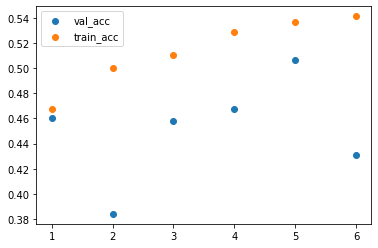

In [24]:
# #fit the mdoel
training_object_mircrop = resnet_20.model.fit(x_train_mc,one_hot_y_train_mc,epochs=6,batch_size=200, validation_split = 0.2,validation_batch_size=4000)
#final prediction
resnet_20.train_test_predict(x_train_mc,y_train_mc,x_test_mc[:10000],y_test_mc[:10000])
plot_accs(training_object_mircrop)

Epoch 1/6
252/252 [==============================] - 281s 1s/step - loss: 28.5112 - acc: 0.2991 - val_loss: 20.5632 - val_acc: 0.2901
Epoch 2/6
252/252 [==============================] - 275s 1s/step - loss: 17.7263 - acc: 0.4203 - val_loss: 15.5404 - val_acc: 0.4523
Epoch 3/6
252/252 [==============================] - 276s 1s/step - loss: 13.9866 - acc: 0.4697 - val_loss: 12.9435 - val_acc: 0.3659
Epoch 4/6
252/252 [==============================] - 278s 1s/step - loss: 11.4673 - acc: 0.4893 - val_loss: 10.4984 - val_acc: 0.4641
Epoch 5/6
252/252 [==============================] - 280s 1s/step - loss: 9.5765 - acc: 0.5028 - val_loss: 8.8677 - val_acc: 0.4741
Epoch 6/6
252/252 [==============================] - 278s 1s/step - loss: 8.1045 - acc: 0.5107 - val_loss: 7.6182 - val_acc: 0.4371
train prediction percentage is {0.43835201936552426}
test prediction percentage is {0.4357}


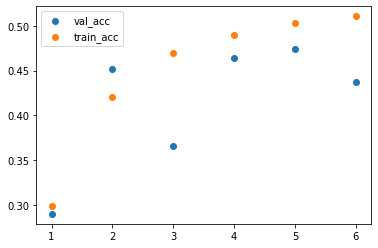

In [64]:
# #fit the mdoel
training_object_mircrop = resnet_20.model.fit(x_train_mc,one_hot_y_train_mc,epochs=6,batch_size=200, validation_split = 0.2,validation_batch_size=4000)
#final prediction
resnet_20.train_test_predict(x_train_mc,y_train_mc,x_test_mc[:10000],y_test_mc[:10000])
plot_accs(training_object_mircrop)

Epoch 1/10
252/252 [==============================] - 275s 1s/step - loss: 6.9155 - acc: 0.5218 - val_loss: 6.3805 - val_acc: 0.5323
Epoch 2/10
252/252 [==============================] - 275s 1s/step - loss: 5.9535 - acc: 0.5309 - val_loss: 5.6636 - val_acc: 0.4857
Epoch 3/10
252/252 [==============================] - 280s 1s/step - loss: 5.1840 - acc: 0.5336 - val_loss: 4.8116 - val_acc: 0.5470
Epoch 4/10
252/252 [==============================] - 276s 1s/step - loss: 4.5618 - acc: 0.5334 - val_loss: 4.4958 - val_acc: 0.4512
Epoch 5/10
252/252 [==============================] - 277s 1s/step - loss: 4.0211 - acc: 0.5440 - val_loss: 3.8429 - val_acc: 0.5125
Epoch 6/10
252/252 [==============================] - 280s 1s/step - loss: 3.6162 - acc: 0.5389 - val_loss: 3.4572 - val_acc: 0.5290
Epoch 7/10
252/252 [==============================] - 277s 1s/step - loss: 3.2645 - acc: 0.5428 - val_loss: 3.2511 - val_acc: 0.4885
Epoch 8/10
252/252 [==============================] - 278s 1s/step - 

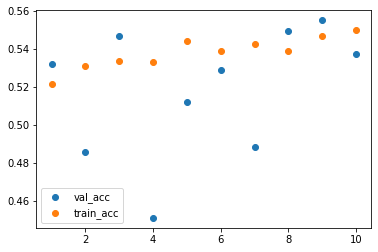

In [66]:
# #fit the mdoel
training_object_mircrop = resnet_20.model.fit(x_train_mc,one_hot_y_train_mc,epochs=10,batch_size=200, validation_split = 0.2,validation_batch_size=4000)
#final prediction
resnet_20.train_test_predict(x_train_mc,y_train_mc,x_test_mc[:10000],y_test_mc[:10000])
plot_accs(training_object_mircrop)

In [67]:
resnet_20.model.save('food/food_mircrop')
resnet_8.model.save('food/food_noaug')

/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: food/food_mircrop/assets
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: food/food_noaug/assets


### 10% increase found from mirror and crop after 20 iterations! not bad at all.